## <center>Optimal Transformation Method (OTM)

### <center>An inverse model for inferring surface fluxes and mixing from gridded hydrographic TS data, <br> by Taimoor Sohail and Jan D. Zika


##### <center>We use an optimal transport method, minimising a cost function which respects the volume and mass conservation, and the fundamental physics of mixing in T-S space. <br>See also: Jan D Zika et al. (2021) [www.doi.org/10.1175/JCLI-D-20-0355.1 ] for a simpler version of this model which optimizes ocean circulation only.
------------

### __The code is laid out as follows:__
#### A) Pre-processing

i) Load necessary modules for computation \
ii) Define key parameters

#### B) Load Data
#### C) Define constraints

i) Define Connectivity \
ii) Define weights

#### D) Run optimisation
#### E) Post-processing

i) Calculate heat/salt budgets \
ii) Calculate surface flux maps

---------

## A) Pre-processing

### i) Load necessary modules for computation

In [1]:
## Module to run the minimisation
from WM_Methods import OTM
## The linear optimisation module
import cvxpy as cp 
## Module to track runtime of cells and loops
import time
from tqdm.notebook import tqdm
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
## Module to load files and handle array computations
import xarray as xr
import numpy as np
## Modules to plot outputs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### ii) Define key parameters

In [36]:
# Flag to set Q_prior (False = 0; True = actual fluxes)
SF = True
# Setting the value of the biases (only works if SF = True)
HF_offset = -5 #W/m2
FW_offset = 0.5 #mm/day
# Specifying the number of BSP bins, 2^n
tree_depth = 4

In [37]:
volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients

# Establish basic constants 
yr2sec = 365.25*24*60*60
# delta(time) in the ACCESS-CM2 model
dt_OG = xr.open_mfdataset('Data/dtime*.nc')
dt_OG['time'] = np.arange(dt_OG.average_DT.size).astype(float)
dt = dt_OG.rename({'time':'Time'})
# Reference density, specific heat capacity and reference salinity
rho = 1035 #kg/m^3
Cp = 3992.10322329649
S0=35

# Range of years over which 'early' and 'late' are defined
dyrs = 9
# Start and end year
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12+((-1850+1979)*12)
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12+((-1850+1979)*12)
range_yrs = init_late-init_early+1

-----------
## B) Load Data



The data is presented as monthly T-S values from ACCESS-CM2, from January 1970 to December 2014 inclusive. The model has already been binned via Binary Space Partitioning according to a specific criterion. Folowing Sohail et al. (2023) [doi:10.1175/JCLI-D-22-0363.1] the BSP partitioning occurs in an xyxyxyx order, shown to minimize variability in the temperature and salinity signals. 



In [38]:
%%time
# Load ACCESS-CM2 data (this data has already been coarsened into basins and BSP bins)
ACCESS_BSP_data = xr.open_mfdataset('Data/*ACCESS_*%i_bins_*.nc' %(tree_depth))

## Early Period
Part_early = ACCESS_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ACCESS_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ACCESS_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')-273.15
V_early = ACCESS_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ACCESS_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ACCESS_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ACCESS_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ACCESS_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')-273.15
V_late = ACCESS_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ACCESS_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

# Basin definitions
Basins = ACCESS_BSP_data.Basin.values

CPU times: user 363 ms, sys: 14.8 ms, total: 378 ms
Wall time: 379 ms


In [39]:
## Convert Offset from W/m2 to W, and from mm/day to kg/s
HF_offset_W = HF_offset*ACCESS_BSP_data.A_sum #W
FW_offset_kg_s = FW_offset*ACCESS_BSP_data.A_sum*rho/(1000*24*3600) #kg/s

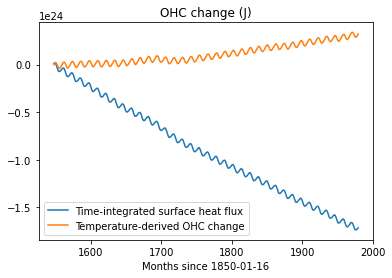

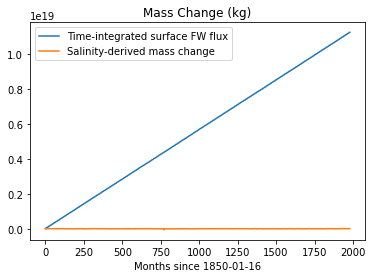

In [40]:
## Check for heat and salt closure
## HEAT
((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sum('Basin').sum('Depth').plot(label='Time-integrated surface heat flux')
((rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Late_period[1])).sum('Basin').sum('Depth'))-(rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).sum('Basin').sum('Depth').isel(Time=Early_period[0]))).plot(label='Temperature-derived OHC change')
plt.title('OHC change (J)')
plt.xlabel('Months since 1850-01-16')
plt.legend()
plt.show()
## SALT
(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time')-((ACCESS_BSP_data.wfo_sum*dt.average_DT).cumsum('Time').isel(Time=slice(0,120)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Time-integrated surface FW flux')
((-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum)-(-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum).isel(Time=slice(0,120)).mean('Time')).sum('Basin').sum('Depth').plot(label='Salinity-derived mass change')
plt.title('Mass Change (kg)')
plt.xlabel('Months since 1850-01-16')
plt.legend()
plt.show()

In [41]:
## Load Q_prior data here
if SF:
    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum = (((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=-1))\
        -(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
    WFO_cumsum = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=-1)\
         -(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))

    ## Convert dflux to equivalent T or S change
    dT_hfds = dhfds/(Cp*rho*V_early) # units: C
    dS_wfo = -dwfo*S0/(rho*V_early) # units: g/kg

    time = ACCESS_BSP_data.Time.values

In [42]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])



Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [43]:
## Add the Q_prior to S_0; T_0 to get the 'initial' state ##
if SF:
    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0


In [44]:
## Here, we create the tracers and volumes matrices, which will be fed into the MTM function

volumes = np.stack((Vol_1, Vol_2), axis=0)/volnorming # Shape: [2 x N]

salinities = np.stack((S_1, S_2), axis=0)
temps = np.stack((T_1, T_2), axis=0)

tracers = np.stack((salinities, temps),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers

In [45]:
print('Total number of bins =', int(Vol_1.shape[0]))
N = int(Vol_1.shape[0])

Total number of bins = 144


---------------
## C) Define Constraints

### i) Define Connectivity

We must define whether a BSP bin is allowed to transport volume to another BSP bin. In the simplest case, all bins are allowed to transport to one another - but this yields nonphysical transport across vast distances and TS bounds.
To improve on this, two connectivity constraints are used: 
1) Are the basins adjacent? This is defined via the connectivity array, below
2) If YES, do the BSP bins have overlapping (or the same) TS boundaries?\
If yes, the bins are connected. If no, they are not.


In [46]:
# Array defining the connection between the 9 basins;
# 1 = connected, 0 = disconnected

connectivity_array = np.zeros((Basins.size,Basins.size))

connectivity_array[0,:] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[1,:] = [1, 1, 1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, 1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, 1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, 1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, 1]
connectivity_array[6,:] = [0, 0, 0, 0, 1, 1, 1, 1, 0]
connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: connectivity_array.T[0,:],\
    Basins[1]: connectivity_array.T[1,:],\
    Basins[2]: connectivity_array.T[2,:],\
    Basins[3]: connectivity_array.T[3,:],\
    Basins[4]: connectivity_array.T[4,:],\
    Basins[5]: connectivity_array.T[5,:],\
    Basins[6]: connectivity_array.T[6,:],\
    Basins[7]: connectivity_array.T[7,:],\
    Basins[8]: connectivity_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

Polar N. Atlantic  Subtropical N. Atlantic  \
Polar N. Atlantic                      1.0                      1.0   
Subtropical N. Atlantic                1.0                      1.0   
Eq. Atlantic                           0.0                      1.0   
S. Atlantic                            0.0                      0.0   
Indian                                 0.0                      0.0   
S. Pacific                             0.0                      0.0   
Eq. Pacific                            0.0                      0.0   
N. Pacific                             0.0                      0.0   
Southern Ocean                         0.0                      0.0   

                         Eq. Atlantic  S. Atlantic  Indian  S. Pacific  \
Polar N. Atlantic                 0.0          0.0     0.0         0.0   
Subtropical N. Atlantic           1.0          0.0     0.0         0.0   
Eq. Atlantic                      1.0          1.0     0.0         0.0   
S. Atlantic                       1.0          1.0     0.0         0.0   
Indian                            0.0          0.0     1.0         0.0   
S. Pacific                        0.0          0.0     0.0         1.0   
Eq. Pacific                       0.0          0.0     1.0         1.0   
N. Pacific                        0.0          0.0     0.0         0.0   
Southern Ocean                    0.0          1.0     1.0         1.0   

                         Eq. Pacific  N. Pacific  Southern Ocean  
Polar N. Atlantic                0.0         0.0             0.0  
Subtropical N. Atlantic          0.0         0.0             0.0  
Eq. Atlantic                     0.0         0.0             0.0  
S. Atlantic                      0.0         0.0             1.0  
Indian                           1.0         0.0             1.0  
S. Pacific                       1.0         0.0             1.0  
Eq. Pacific                      1.0         1.0             0.0  
N. Pacific                       1.0         1.0             0.0  
Southern Ocean                   0.0         0.0             1.0

In [47]:
# Define whether a bin is connected to every other bin
# The two constraints used are: are the basins adjacent? 
# If yes, are the bin indices the same? 
# If yes, the bins are connected; if no, they are not connected. 

connected = np.zeros((Vol_1.size, Vol_1.size))

for i in tqdm(range(Vol_1.size)):
    for j in range(Vol_2.size):
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]>0:
            connected[i,j] = 1

  0%|          | 0/144 [00:00<?, ?it/s]

### ii) Define Weights, $\bf{w_j}$

##### Load the T and S standard deviations, $\sigma_T; \sigma_S$, for weights $w_j$

In [48]:
#### We have loaded the standard deviations into an intermediate netCDF file as the std is calculated on the full, time-varying T/S distribution, which is quite large in size

ST_scale = xr.open_mfdataset('Data/ST_standard_devs.nc')

# Weights are 1/std
T_scale = 1/ST_scale.T_std.values
S_scale = 1/ST_scale.S_std.values

In [49]:
# Now create the weight matrix, which is a combination of 1/std(tracer) and 1/Area
# Load A_late for the weights
A_2_modified = A_2.copy()
# Set the minimum area (as zero will lead to inf values)
# This is only relevant for the Q_prior = 0 case which does not work with a 'hard' area constraint
A_2_modified[A_2_modified==0] = np.nanmin(A_2_modified[A_2_modified>0]) 

area_weight = np.sqrt(areanorming/A_2_modified)

## Define the 'hard' area constraint that will be fed into the MTM function and enforce that non-outcropping 
## water masses have no net air-sea flux. Only works with Q_prior = known. 
area_cons = A_2/A_2-1
area_cons[np.isnan(area_cons)] = 1

weights = np.stack((S_scale*area_weight, T_scale*area_weight), axis=0) # Shape: An [M x N] matrix

hard_area = np.stack((area_cons,area_cons), axis=0)

-----------------
## D) Run Optimisation

In [50]:
## We run the optimiser to get the transports between water masses and the T,S mixed and T,S adjustment
## Function has form MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = constraints, 
#                                  weights=weights, hard_area = hard_area)
if SF:
    result = OTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = connected, weights=weights, hard_area = hard_area)
else:
    result = OTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = connected, weights=weights)

g_ij = result['g_ij']*volnorming ## An [N x N] matrix of transports between WMs
Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM
G = result['G']*volnorming ## An [ix] matrix of transports between WMs

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jun 01 04:48:09 PM: Your problem has 6912 variables, 3 constraints, and 0 parameters.
(CVXPY) Jun 01 04:48:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 01 04:48:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 01 04:48:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 01 04:48:09 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 01 04:48:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [51]:
## Break down the Mixing and Adjustment matrices into their constituent tracers
dT_mixing = Mixing[1,:]
dS_mixing = Mixing[0,:]
dS_adj = Adjustment[0,:]
dT_adj = Adjustment[1,:]

In [52]:
file_path = '../MIN_MIX_FINAL/Optimisation_results/ACCESS_CM2_known_offset_transports.nc'

import os
if os.path.exists(file_path):
   os.remove(file_path)
   print('File deleted')

da_dT_mixing = xr.DataArray(data = dT_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Mixing", units="\Delta K", variable_id="EN4 Tmix"))
da_dS_mixing = xr.DataArray(data = dS_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Mixing", units="\Delta g/kg", variable_id="EN4 Smix"))
da_dT_adjustment = xr.DataArray(data = dT_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Adjustment", units="\Delta K", variable_id="EN4 Tadj"))
da_dS_adjustment = xr.DataArray(data = dS_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Adjustment", units="\Delta g/kg", variable_id="EN4 Sadj"))
da_gij = xr.DataArray(data = g_ij, dims = ["WM_initial", "WM_final"],
                           coords=dict(WM_initial = np.arange(0,N), WM_final = np.arange(0,N)),
                        attrs=dict(description="Volume transport", units="m^3", variable_id="EN4 Gij"))

## Create xarray DataSet that will hold all these DataArrays
ds_BSP = xr.Dataset()
ds_BSP['dT_mixing'] = da_dT_mixing
ds_BSP['dS_mixing'] = da_dS_mixing
ds_BSP['dT_adjustment'] = da_dT_adjustment
ds_BSP['dS_adjustment'] = da_dS_adjustment
ds_BSP['gij'] = da_gij

ds_BSP.to_netcdf(file_path, mode='w')
print('File saved')


File deleted
File saved


--------

## E) Perform post-processing analysis

### i) Calculating Basin-scale budgets from the OTM code

##### Calculate the net change in ocean heat content and $Q_{prior}$ and $Q_{adj}$ in each Basin

In [18]:
### Calculate the total ocean heat content (OHC) and net Q_prior heat flux (hfds) change between t=0 and t=1 in each Basin
OHC_early = rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth') # J
OHC_late = rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth') # J

hfds_early = ((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth') # J
hfds_late = ((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth') # J

hfds_change = ((hfds_late-hfds_early)/(range_yrs*yr2sec*10**12)).values # units: TW
OHC_change = ((OHC_late-OHC_early)/(range_yrs*yr2sec*10**12)).values # units: TW
### Calculate the change in net Q_adjustment heat flux between t=0 and t=1 in each Basin
dhfds_adj = dT_adj.reshape(V_late.shape)*(Cp*rho*V_late.values) # units: J
hfds_adj_change = np.nansum(dhfds_adj, axis=-1)/(range_yrs*yr2sec*10**12) # units: TW

##### Calculate the meridional heat transport (MHT) in each Basin

In [19]:
### First we define an array of connections between each basin
# 1 = connected (sign convention: North = +ve, East = +ve), 0 = disconnected
d_ij = np.zeros((Basins.size,Basins.size))

d_ij[0,:] = [1, -1, 0, 0, 0, 0, 0, 0, 0]
d_ij[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
d_ij[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
d_ij[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
d_ij[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
d_ij[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
d_ij[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
d_ij[7,:] = [0, 0, 0, 0, 0, 0, -1, 1, 0]
d_ij[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

### The section transport is then g_ij between Basins times this sign convention, in Sverdrups
section_trans = np.zeros((Vol_1.size,Vol_1.size))
for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(range_yrs*yr2sec*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] # units: Sv

### Sum the section transport across all initial water masses so you get a total transport from one basin to another

section_trans_temp = np.zeros((Vol_1.size, Basins.size))
for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1) # units: Sv

### basin_connex is an array of numbers which will be used to pinpoint the indices in the 144x144 array that belong to Basins i and j when calculating connectivity
basin_connex = np.array([[0,1],
                [1,2],
                [2,3],
                [3,8],
                [4,8],
                [4,6],
                [5,8],
                [6,5],
                [7,6]]).astype(int)
### T and section_joined are the temps and corresponding transports between a given connected Basin pair (as defined by basin_connex)
# So, sum(T*section) should give you the total net heat transp[ort between the Basin pair

T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])

heat_trans = T_joined*section_joined*rho*Cp*10**6 # units: W
### Sum along the entire section to get the total heat flux across the section
HF_section_tot = np.nansum(heat_trans, axis=-1)/10**12 # units: TW


In [20]:
### The total heat flux into a basin will be the sum of northward and southward section transport, so we need to define the total transport out as this sum:
net_heat_trans_Basins = [HF_section_tot[0],\
    HF_section_tot[1]-HF_section_tot[0],\
        HF_section_tot[2]-HF_section_tot[1],\
            HF_section_tot[3]-HF_section_tot[2],\
                HF_section_tot[4]-HF_section_tot[5],\
                    HF_section_tot[6]-HF_section_tot[7],\
                        HF_section_tot[7]-HF_section_tot[8]+HF_section_tot[5],\
                            HF_section_tot[8],\
                            -HF_section_tot[4]-HF_section_tot[6]-HF_section_tot[3]]

### where net_heat_trans_Basins[j] corresponds to the net transport into (or out of) Basin[j]

##### Calculate the net change in ocean salt content and $Q_{prior}$ and $Q_{adj}$ in each Basin, and the net meridional freshwater transport

In [21]:
### The same routine is applied to salt as above. For more details on the code, see comments in above heat transport calculations.

OSC_early = ((-ACCESS_BSP_data.S_mean/S0*ACCESS_BSP_data.V_sum)).isel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth') # m3
OSC_late = ((-ACCESS_BSP_data.S_mean/S0*ACCESS_BSP_data.V_sum)).isel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth') # m3

wfo_early = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth')/rho # m3
wfo_late = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth')/rho # m3

wfo_change = ((wfo_late-wfo_early)/(range_yrs*yr2sec*10**6)).values # units: Sv
OSC_change = ((OSC_late-OSC_early)/(range_yrs*yr2sec*10**6)).values # units: Sv

dwfo_adj = -dS_adj.reshape(V_late.shape)*(rho*V_late.values)/S0 # units: kg
wfo_adj_change = np.nansum(dwfo_adj, axis=-1)/(rho*range_yrs*yr2sec*10**6) # units: Sv


S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
for i in range(int(np.size(basin_connex)/2)):
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])

salt_trans = S_joined/S0*section_joined # units: Sv
FWF_section_tot = np.nansum(salt_trans, axis=-1) # units: Sv

net_salt_trans_Basins = [FWF_section_tot[0],\
    FWF_section_tot[1]-FWF_section_tot[0],\
        FWF_section_tot[2]-FWF_section_tot[1],\
            FWF_section_tot[3]-FWF_section_tot[2],\
                FWF_section_tot[4]-FWF_section_tot[5],\
                    FWF_section_tot[6]-FWF_section_tot[7],\
                        FWF_section_tot[7]-FWF_section_tot[8]+FWF_section_tot[5],\
                            FWF_section_tot[8],\
                            -FWF_section_tot[4]-FWF_section_tot[6]-FWF_section_tot[3]]

In [22]:
d = {'OHC Change [TW]': np.append(OHC_change, np.nansum(OHC_change)),\
    'Surface Heat flux Change [TW]': np.append(hfds_change, np.nansum(hfds_change)),\
            'Adjustment heat flux Change [TW]': np.append(hfds_adj_change, np.nansum(hfds_adj_change)),\
    'Net Meridional Heat Transport [TW]': np.append(net_heat_trans_Basins, np.nansum(net_heat_trans_Basins))}    
table_HC = pd.DataFrame(data=d, index=np.append(Basins, 'Global'))
d = {'FW Change [Sv]': np.append(OSC_change, np.nansum(OSC_change)),\
    'Surface FW flux Change [Sv]': np.append(wfo_change, np.nansum(wfo_change)),\
            'Adjustment FW flux Change [Sv]': np.append(wfo_adj_change, np.nansum(wfo_adj_change)),\
    'Net Meridional FW Transport [Sv]': np.append(net_salt_trans_Basins, np.nansum(net_salt_trans_Basins))}    
table_FW = pd.DataFrame(data=d, index=np.append(Basins, 'Global'))

display(table_HC)
display(table_FW)

OHC Change [TW]  Surface Heat flux Change [TW]  \
Polar N. Atlantic              19.801560                    -635.951687   
Subtropical N. Atlantic        43.335840                    -232.101693   
Eq. Atlantic                   15.559423                     457.090459   
S. Atlantic                    20.763602                      77.904426   
Indian                         23.586685                     -53.354329   
S. Pacific                     19.749229                     -58.153987   
Eq. Pacific                    11.429877                    1493.148439   
N. Pacific                     38.383094                    -458.890324   
Southern Ocean                 86.599270                    -310.259341   
Global                        279.208580                     279.431963   

                         Adjustment heat flux Change [TW]  \
Polar N. Atlantic                                0.539018   
Subtropical N. Atlantic                          0.512627   
Eq. Atlantic                                     0.261117   
S. Atlantic                                      0.330461   
Indian                                           0.889715   
S. Pacific                                       0.781205   
Eq. Pacific                                      0.804588   
N. Pacific                                       1.200207   
Southern Ocean                                   1.824310   
Global                                           7.143248   

                         Net Meridional Heat Transport [TW]  
Polar N. Atlantic                              6.534265e+02  
Subtropical N. Atlantic                        2.695503e+02  
Eq. Atlantic                                  -4.434911e+02  
S. Atlantic                                   -5.456847e+01  
Indian                                         7.871641e+01  
S. Pacific                                     8.881770e+01  
Eq. Pacific                                   -1.478210e+03  
N. Pacific                                     4.723698e+02  
Southern Ocean                                 4.133884e+02  
Global                                         1.136868e-13

FW Change [Sv]  Surface FW flux Change [Sv]  \
Polar N. Atlantic              0.011810                     0.451586   
Subtropical N. Atlantic       -0.045841                    -0.589734   
Eq. Atlantic                  -0.008320                     0.273062   
S. Atlantic                   -0.006763                    -0.448757   
Indian                        -0.002573                    -0.786947   
S. Pacific                     0.022335                    -0.544452   
Eq. Pacific                    0.006828                     0.736265   
N. Pacific                     0.031617                    -0.068648   
Southern Ocean                -0.006796                     0.981112   
Global                         0.002297                     0.003487   

                         Adjustment FW flux Change [Sv]  \
Polar N. Atlantic                             -0.000028   
Subtropical N. Atlantic                       -0.000027   
Eq. Atlantic                                  -0.000014   
S. Atlantic                                   -0.000017   
Indian                                        -0.000047   
S. Pacific                                    -0.000041   
Eq. Pacific                                   -0.000042   
N. Pacific                                    -0.000063   
Southern Ocean                                -0.000095   
Global                                        -0.000374   

                         Net Meridional FW Transport [Sv]  
Polar N. Atlantic                                0.440136  
Subtropical N. Atlantic                         -0.542481  
Eq. Atlantic                                     0.282342  
S. Atlantic                                     -0.442630  
Indian                                          -0.788756  
S. Pacific                                      -0.569165  
Eq. Pacific                                      0.727171  
N. Pacific                                      -0.092041  
Southern Ocean                                   0.985423  
Global                                           0.000000

------

### ii) Mapping $Q_{prior}$ and $Q_{adj}$ onto surface flux fields

In [23]:
### Load the Basin and water mass masks for ACCESS-CM2
ACCESS_masks = xr.open_mfdataset('Data/ACCESS_masks.nc')
basin_mask = ACCESS_masks.basin_mask.values
WM_mask = ACCESS_masks.water_mass_mask.values

## Load the latitudes and longitudes for plotting
lats = ACCESS_masks.geolat_t.values
lons = ACCESS_masks.geolon_t.values

if SF:
    ## Get Q_prior in W/m2 and mm/day
    dhfds_flux = (dhfds/(range_yrs*yr2sec*A_early)).values
    dwfo_flux = (dwfo/(range_yrs*yr2sec*A_early*rho)*1000*24*3600).values

## Get Q_adj in W/m2 and mm/day
dhfds_flux_adj = dhfds_adj/(range_yrs*yr2sec*A_late.values)
dwfo_flux_adj = dwfo_adj/(range_yrs*yr2sec*A_late.values*rho)*1000*24*3600

In [24]:
### Map the Q_prior onto the relevant basin and water mass based on the defined masks
if SF:
        hfds_tot = 0
        wfo_tot = 0
        for i in (range(SA_early.shape[-1])):
                tmp_dhfds = 0
                tmp_dwfo = 0
                for j in range(Basins.size):
                        tmp = basin_mask[j,:,:]*WM_mask[i,:,:]*dhfds_flux[j,i]
                        tmp[np.isnan(tmp)] = 0
                        tmp_dhfds = tmp+tmp_dhfds
                        tmp = basin_mask[j,:,:]*WM_mask[i,:,:]*dwfo_flux[j,i]
                        tmp[np.isnan(tmp)] = 0
                        tmp_dwfo = tmp+tmp_dwfo
                hfds_tot = tmp_dhfds+hfds_tot
                wfo_tot = tmp_dwfo+wfo_tot

### Now do the same for the Q_adj
dS_adj_tot = 0
dT_adj_tot = 0
for i in (range(SA_early.shape[-1])):
    tmp_dS_adj = 0
    tmp_dT_adj = 0
    for j in range(Basins.size):
            tmp = basin_mask[j,:,:]*WM_mask[i,:,:]*dwfo_flux_adj[j,i]
            tmp[np.isnan(tmp)] = 0
            tmp_dS_adj = tmp+tmp_dS_adj
            tmp = basin_mask[j,:,:]*WM_mask[i,:,:]*dhfds_flux_adj[j,i]
            tmp[np.isnan(tmp)] = 0
            tmp_dT_adj = tmp+tmp_dT_adj
    dS_adj_tot = tmp_dS_adj+dS_adj_tot
    dT_adj_tot = tmp_dT_adj+dT_adj_tot

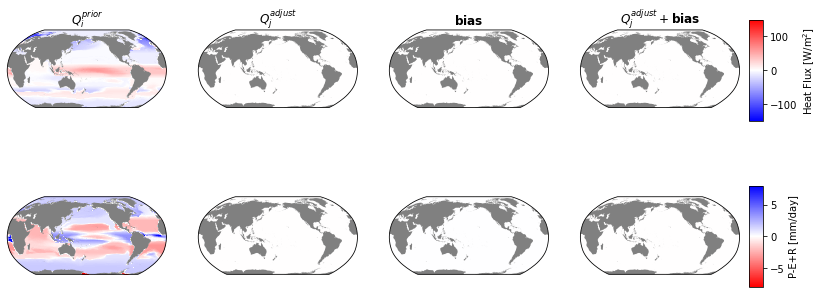

In [25]:
#### Below, we plot the maps as calculated above. This code should adapt automatically to the 3 cases presented in the mnauscript

fig  = plt.figure(1, figsize = (17.5*0.75, 7.5*0.75))
gs = gridspec.GridSpec(2,4)
gs.update(wspace = 0.2, hspace=0.2)

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
        plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[0,2], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[0,3], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[1,2], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[1,3], projection=ccrs.Robinson(central_longitude=180))

if (HF_offset!=0 or FW_offset!=0):
        minv, maxv = -abs(HF_offset),abs(HF_offset)
        ax3.pcolormesh(lons, lats,  dT_adj_tot/dT_adj_tot*HF_offset, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())
else:
        minv, maxv = -150,150
        ax3.pcolormesh(lons, lats,  dT_adj_tot/dT_adj_tot*0, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

if SF:
        ax1.pcolormesh(lons, lats,  hfds_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())
else:
        minv, maxv = -3,3
        ax1.pcolormesh(lons, lats,  dT_adj_tot/dT_adj_tot*0, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

if (HF_offset!=0 or FW_offset!=0):
        ax1.pcolormesh(lons, lats,  dT_adj_tot/dT_adj_tot*0, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

ax2.pcolormesh(lons, lats,  dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

if (HF_offset!=0 or FW_offset!=0):
        ax4.pcolormesh(lons, lats,  dT_adj_tot/dT_adj_tot*HF_offset+dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())
else:
        ax4.pcolormesh(lons, lats,  dT_adj_tot/dT_adj_tot*0+dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

cax = fig.add_axes([0.91, 0.58, 0.015, 0.25])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Heat Flux [W/m$^2$]')

if (HF_offset!=0 or FW_offset!=0):
        minv, maxv = -abs(FW_offset),abs(FW_offset)
        ax7.pcolormesh(lons, lats,  dS_adj_tot/dS_adj_tot*FW_offset, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())
else:
        minv, maxv = -8,8
        ax7.pcolormesh(lons, lats,  dS_adj_tot/dS_adj_tot*0, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

if SF:
        ax5.pcolormesh(lons, lats,  wfo_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())
else:
        minv, maxv = -0.2,0.2
        ax5.pcolormesh(lons, lats,  dS_adj_tot/dS_adj_tot*0, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

if (HF_offset!=0 or FW_offset!=0):
        ax5.pcolormesh(lons, lats,  dS_adj_tot/dS_adj_tot*0, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

ax6.pcolormesh(lons, lats,  dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

if (HF_offset!=0 or FW_offset!=0):
        ax8.pcolormesh(lons, lats,  dS_adj_tot/dS_adj_tot*FW_offset+dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())
else:
        ax8.pcolormesh(lons, lats,  dS_adj_tot/dS_adj_tot*0+dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

cax = fig.add_axes([0.91, 0.17, 0.015, 0.25])
m = plt.cm.ScalarMappable(cmap='bwr_r')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('P-E+R [mm/day]')

ax1.set_title(r'$Q_i^{prior}$')
ax2.set_title(r'$Q_j^{adjust}$')
ax3.set_title(r'$\bf{bias}$')
ax4.set_title(r'$Q_j^{adjust}+\bf{bias}$')

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax6.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax7.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax8.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))

plt.show()